<a href="https://colab.research.google.com/github/danielferber/FacadeOPL/blob/master/Covid_19_CNN_DataFlow_rapido_Ferber.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Certificar de que está executando em OREGON!!!!!!!
# Se não estiver conectado em oregon, redefina o ambiente de execução

!curl ipinfo.io
# TEste

{
  "ip": "35.197.86.220",
  "hostname": "220.86.197.35.bc.googleusercontent.com",
  "city": "The Dalles",
  "region": "Oregon",
  "country": "US",
  "loc": "45.5946,-121.1787",
  "org": "AS15169 Google LLC",
  "postal": "97058",
  "timezone": "America/Los_Angeles",
  "readme": "https://ipinfo.io/missingauth"
}

In [ ]:
from google.colab import auth
auth.authenticate_user()
project_id = 'felipemartim'
bucket_name = 'mdc007-oregon'
source_dir = 'prepared'
source_prefix = 'noBK-Rect-Center'
dataset_dir = 'dataset'
dataset_train_dir = dataset_dir+'/'+source_prefix+'/train'
dataset_val_dir = dataset_dir+'/'+source_prefix+'/val'
baseline_resolution = 128
baseline_batch_size = 32
baseline_id = source_prefix+'-b32-r128-lr0001'
baseline_lr = 0.0001
baseline_classes = ['Normal', 'CP', 'NCP']

! rm -rf sample_data
! mkdir -p results

In [ ]:
import tensorflow as tf
import numpy as np
import PIL
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint,CSVLogger,Callback
import datetime
import subprocess
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
import os

print('tensorflow:', tf.__version__)
print('numpy:', np.__version__)
print('PIL:', PIL.__version__)


tensorflow: 2.3.0
numpy: 1.18.5
PIL: 7.0.0


In [ ]:
! gcloud config set project {project_id}
#! rm -rf dataset
! mkdir -p dataset

#! time gsutil -m cp gs://{bucket_name}/{source_dir}/{source_prefix}-val.zip {dataset_dir}/
#! time unzip -n -q {dataset_dir}/{source_prefix}-val.zip -d {dataset_dir}/
#! rm {dataset_dir}/{source_prefix}-val.zip

! time gsutil -m cp gs://{bucket_name}/{source_dir}/{source_prefix}-train.zip {dataset_dir}/
! time unzip -n -q {dataset_dir}/{source_prefix}-train.zip -d {dataset_dir}/
! rm {dataset_dir}/{source_prefix}-train.zip

Updated property [core/project].
Copying gs://mdc007-oregon/prepared/noBK-Rect-Center-train.zip...
Resuming download for dataset/noBK-Rect-Center-train.zip component 0
Resuming download for dataset/noBK-Rect-Center-train.zip component 1
Resuming download for dataset/noBK-Rect-Center-train.zip component 2
Resuming download for dataset/noBK-Rect-Center-train.zip component 3
| [1/1 files][  4.6 GiB/  4.6 GiB] 100% Done  75.8 MiB/s ETA 00:00:00           
Operation completed over 1 objects/4.6 GiB.                                      

real	2m4.710s
user	0m28.369s
sys	0m9.460s

real	1m43.302s
user	0m35.113s
sys	0m7.882s


In [ ]:
# Disponibilizar o dataset 'train_ds' com imagens em cache.
# Este data set deve ser usado como entrada para um segundo mecanismo de 
# aumentação de dados.

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_train_dir,
    image_size=(baseline_resolution, baseline_resolution),
    label_mode='categorical',
    color_mode="grayscale",
    batch_size=baseline_batch_size,
    shuffle=True,
    class_names = baseline_classes,
    interpolation="bilinear").cache().prefetch(buffer_size=40)

Found 61782 files belonging to 3 classes.


In [ ]:
# Disponibilizar a função 'calcular_acuracia_validacao(modelo)'

validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_val_dir,
    image_size=(baseline_resolution, baseline_resolution),
    label_mode='categorical',
    color_mode="grayscale",
    batch_size=baseline_batch_size,
    shuffle=False,
    class_names = baseline_classes,
    interpolation="bilinear").prefetch(buffer_size=40)

validation_images = []
validation_labels = []
for images, labels in validation_ds.take(-1):
  validation_images.extend(images.numpy())
  validation_labels.extend(np.argmax(labels.numpy(), axis=1))
validation_images = np.asarray(validation_images)
validation_labels = np.asarray(validation_labels)

Found 21036 files belonging to 3 classes.


In [ ]:
def calcular_matrix_confusao(modelo):
  predicted_labels_one_hot = modelo.predict(validation_images)
  predicted_labels = np.argmax(predicted_labels_one_hot, axis=1)
  return confusion_matrix(validation_labels, predicted_labels)

def calcular_acuracia_validacao(cmf):
  cmf = cmf.astype(np.float)
  cm_acc = cmf.diagonal().sum() / cmf.sum()      
  cm_bal_acc = (cmf.diagonal() / cm.sum(axis=1)).sum() / 3
  return cm_acc, cm_bal_acc


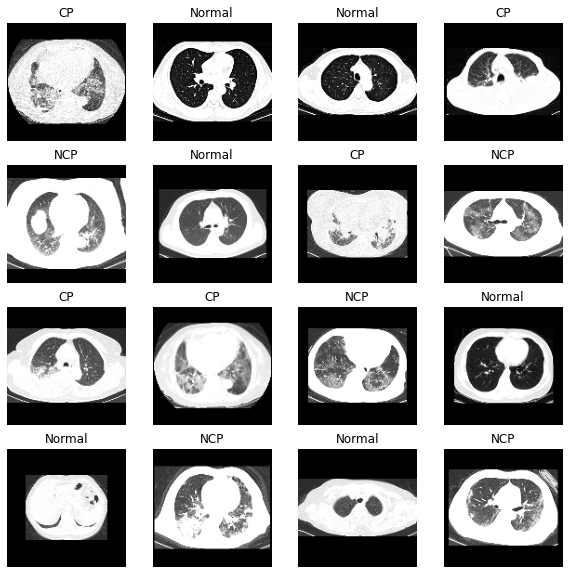

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    image_array = images[i].numpy().astype("uint8")
    image_array.shape = (baseline_resolution,baseline_resolution)
    plt.imshow(image_array, cmap="gray")
    plt.title(baseline_classes[labels[i].numpy().argmax()])
    plt.axis("off")

In [ ]:
train_CP_count = len(os.listdir(dataset_train_dir+'/CP'))
train_NCP_count = len(os.listdir(dataset_train_dir+'/NCP'))
train_Normal_count = len(os.listdir(dataset_train_dir+'/Normal'))
train_total = train_Normal_count + train_CP_count + train_NCP_count
train_class_weights = {0: train_total/train_Normal_count/3,
                       1: train_total/train_CP_count/3,
                       2: train_total/train_NCP_count/3}
print(train_class_weights)

{0: 0.757104518216242, 1: 0.93350256108064, 2: 1.644888178913738}


In [ ]:
class UploadCallback(Callback):
  def on_epoch_end(self, epoch, logs=None):
    command = ['gsutil', '-m', 'rsync', '-r', 'results', 'gs://'+bucket_name+'/results/'+baseline_id]
    subprocess.run(command)

def scheduler(epoch, lr):
  if epoch >= 10:
    lr *= 0.5
  elif epoch >= 3:
    lr *= 0.7
 
  print("Learning rate:", lr)
  return lr

class EvaluationCallback(Callback):
    def on_epoch_end(self, epoch, logs={}):
      cm = calcular_matrix_confusao(baseline_model)
      cmf = cm.astype(np.float)
      cmf = cmf/cmf.sum()*100
      cmf = cmf.round(2)
      print(cmf)

      cm_acc, cm_bal_acc = calcular_acuracia_validacao(cm)
      logs['val_accuracy'] = cm_acc
      logs['val_bal_accuracy'] = cm_bal_acc
      print('val_accuracy e val_bal_accuracy:', cm_acc, cm_bal_acc)
      return logs
callback_evaluation = EvaluationCallback()

    
baseline_date = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S')
callback_lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)
callback_modelsave = ModelCheckpoint('results/'+baseline_id+'_'+baseline_date+ "_ep-{epoch:02d}.hdf5", verbose=1)
callback_upload = UploadCallback()

# Os parâmetros foram escolhidos todos ao acaso, sem nenhum tipo de racionalização.
baseline_model = tf.keras.Sequential()
baseline_model.add(layers.Input(shape=(baseline_resolution, baseline_resolution, 1), name="input"))
baseline_model.add(layers.Conv2D(32, 3, padding='same', activation='selu', kernel_initializer = 'he_uniform', name="a1"))
baseline_model.add(layers.Conv2D(32, 3, padding='same', activation='selu', kernel_initializer = 'he_uniform', name="a2"))
baseline_model.add(layers.MaxPooling2D())
baseline_model.add(layers.Dropout(0.2))
baseline_model.add(layers.Conv2D(64, 3, padding='same', activation='selu', kernel_initializer = 'he_uniform', name="b1"))
baseline_model.add(layers.Conv2D(64, 3, padding='same', activation='selu', kernel_initializer = 'he_uniform', name="b2"))
baseline_model.add(layers.MaxPooling2D())
baseline_model.add(layers.Dropout(0.2))
baseline_model.add(layers.Conv2D(128, 3, padding='same', activation='selu', kernel_initializer = 'he_uniform', name="c1"))
baseline_model.add(layers.Conv2D(128, 3, padding='same', activation='selu', kernel_initializer = 'he_uniform', name="c2"))
baseline_model.add(layers.MaxPooling2D())
baseline_model.add(layers.Dropout(0.2))
baseline_model.add(layers.Flatten())
baseline_model.add(layers.Dense(256, activation='selu', kernel_initializer = 'he_uniform', name="d1"))
baseline_model.add(layers.Dense(128, activation='selu', kernel_initializer = 'he_uniform', name="d2"))
baseline_model.add(layers.Dense(3, activation='softmax'))
baseline_model.summary()

baseline_model.compile(loss='categorical_crossentropy', 
                       optimizer=tf.keras.optimizers.Adam(learning_rate=baseline_lr), 
                       metrics=[tf.keras.metrics.CategoricalAccuracy(name='accuracy')])

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
a1 (Conv2D)                  (None, 128, 128, 32)      320       
_________________________________________________________________
a2 (Conv2D)                  (None, 128, 128, 32)      9248      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 64, 64, 32)        0         
_________________________________________________________________
b1 (Conv2D)                  (None, 64, 64, 64)        18496     
_________________________________________________________________
b2 (Conv2D)                  (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 32, 32, 64)       

In [ ]:
callback_csv = CSVLogger('results/'+baseline_id+'_'+baseline_date+"_ep-01-10.csv")
baseline_history1 = baseline_model.fit(train_ds, epochs=10,
                                       callbacks=[callback_lr_scheduler, callback_evaluation, callback_csv, callback_modelsave, callback_upload])

New learning rate: 4.999999873689376e-05
Epoch 1/10
1931/1931 [==============================] - ETA: 0s - loss: 10.2416 - accuracy: 0.7157[[27.35 12.55  3.39]
 [ 0.67 30.66  3.85]
 [ 0.04  4.52 16.97]]
val_accuracy e val_bal_accuracy: 0.7498098497813273 0.763853879903162

Epoch 00001: saving model to results/noBK-Rect-Center-b32-r128-lr0001_2020-12-01-05-29-55_ep-01.hdf5
1931/1931 [==============================] - 101s 52ms/step - loss: 10.2416 - accuracy: 0.7157
New learning rate: 2.499999936844688e-05
Epoch 2/10
1930/1931 [============================>.] - ETA: 0s - loss: 0.5912 - accuracy: 0.8592[[33.53  9.33  0.44]
 [ 0.65 33.21  1.31]
 [ 0.05  5.05 16.42]]
val_accuracy e val_bal_accuracy: 0.8316695189199468 0.8271699850784836

Epoch 00002: saving model to results/noBK-Rect-Center-b32-r128-lr0001_2020-12-01-05-29-55_ep-02.hdf5
1931/1931 [==============================] - 101s 52ms/step - loss: 0.5911 - accuracy: 0.8592
New learning rate: 1.249999968422344e-05
Epoch 3/10
1930/1931

Building synchronization state...
Starting synchronization...
Copying file://results/noBK-Rect-Center-b32-r128-lr0001_2020-12-01-04-56-26-accuracy.png [Content-Type=image/png]...
/ [1/1 files][ 20.1 KiB/ 20.1 KiB] 100% Done                                    
Operation completed over 1 objects/20.1 KiB.                                     


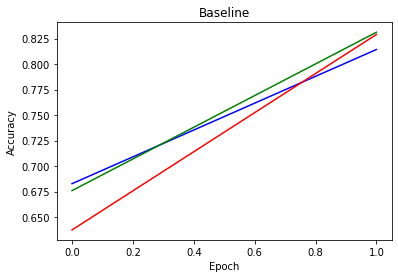

In [ ]:
train_acc   = baseline_history1.history['accuracy']
val_acc     = baseline_history1.history['val_accuracy']
val_bal_acc = baseline_history1.history['val_bal_accuracy']

xrn = range(len(train_acc)) 

plt.figure()
plt.plot(xrn,train_acc, color='blue')
plt.plot(xrn,val_acc, color='red')
plt.plot(xrn,val_bal_acc, color='green')
plt.title('Baseline')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.savefig('results/'+baseline_id+'_'+baseline_date+'_accuracy-plot.png')

! gsutil -m rsync -r results gs://{bucket_name}/results/{baseline_id}

In [ ]:
cmf = calcular_matrix_confusao(baseline_model)
print(cmf)
with open('results/'+baseline_id+'_'+baseline_date+'_confusion-matrix-int.txt', 'w') as writefile:
    writefile.write(str(cmf))

cmf = cmf.astype(np.float)
cmf = cmf/cmf.sum()*100
cmf = cmf.round(2)
print(cmf)
with open('results/'+baseline_id+'_'+baseline_date+'_confusion-matrix-rel.txt', 'w') as writefile:
    writefile.write(str(cmf/cmf.sum()*100))

cm_acc, cm_bal_acc = calcular_acuracia_validacao(cmf)
print("Accuracy:", round(cm_acc*100,3))
print("Balanced Accuracy:", round(cm_bal_acc*100,3))

with open('results/'+baseline_id+'_'+baseline_date+'_accuracy.txt', 'w') as writefile:
    writefile.write(str(cm_acc*100))
with open('results/'+baseline_id+'_'+baseline_date+'_balanced-accuracy.txt', 'w') as writefile:
    writefile.write(str(cm_bal_acc*100))

! gsutil -m rsync -r results gs://{bucket_name}/results/{baseline_id}

[[7914  957  236]
 [ 642 5587 1171]
 [  72  518 3939]]
[[37.62  4.55  1.12]
 [ 3.05 26.56  5.57]
 [ 0.34  2.46 18.73]]
Accuracy: 82.91
Balanced Accuracy: 83.132
Building synchronization state...
Starting synchronization...
Copying file://results/noBK-Rect-Center-b32-r128-lr0001_2020-12-01-04-56-26_balanced-accuracy.txt [Content-Type=text/plain]...
Copying file://results/noBK-Rect-Center-b32-r128-lr0001_2020-12-01-04-56-26_confusion-matrix-rel.txt [Content-Type=text/plain]...
Copying file://results/noBK-Rect-Center-b32-r128-lr0001_2020-12-01-04-56-26_confusion-matrix-int.txt [Content-Type=text/plain]...
Copying file://results/noBK-Rect-Center-b32-r128-lr0001_2020-12-01-04-56-26_accuracy.txt [Content-Type=text/plain]...
Copying file://results/noBK-Rect-Center-b32-r128-lr0001_2020-12-01-04-56-26_confusion-matrix.txt [Content-Type=text/plain]...
/ [5/5 files][  268.0 B/  268.0 B] 100% Done                                    
Operation completed over 5 objects/268.0 B.                      